In [2]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_from_disk
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tabulate import tabulate

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
full_dataset = load_from_disk('../data/full_dataset_new', keep_in_memory=True)

split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']

test_x = np.array(test_dataset['embedding'])
test_y = np.array(test_dataset['labels'])

from torch.utils.data import Dataset, DataLoader, Subset

class EmbeddingDataset(Dataset):
    def __init__(self, hf_dataset):
        self.embeddings = hf_dataset["embedding"]
        self.labels = hf_dataset["labels"]
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
        label = self.labels[idx]
        return emb, label

train_ds = EmbeddingDataset(train_dataset)
test_ds = EmbeddingDataset(test_dataset)

In [4]:
class DNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.5):
        super(DNNClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        logits = self.fc(x)
        return logits

def train_and_evaluate(model, train_loader, test_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_acc = correct / total
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for embeddings, labels in test_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                test_correct += (preds == labels).sum().item()
                test_total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        test_loss = test_running_loss / test_total
        test_acc = test_correct / test_total
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    
    return test_acc, all_preds, all_labels

/tmp/ipykernel_44187/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)



使用訓練資料數量: 20 筆
開始訓練...


/tmp/ipykernel_44187/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 1: Train Loss=1.0245, Train Acc=0.3500 | Test Loss=0.6825, Test Acc=0.8567
Epoch 2: Train Loss=0.6274, Train Acc=0.8000 | Test Loss=0.4787, Test Acc=0.8968
Epoch 3: Train Loss=0.3111, Train Acc=0.9500 | Test Loss=0.3667, Test Acc=0.8994
Epoch 4: Train Loss=0.2783, Train Acc=0.9500 | Test Loss=0.3202, Test Acc=0.8928
Epoch 5: Train Loss=0.2186, Train Acc=0.9000 | Test Loss=0.3169, Test Acc=0.8826
Epoch 6: Train Loss=0.2224, Train Acc=0.9000 | Test Loss=0.3391, Test Acc=0.8674
Epoch 7: Train Loss=0.1630, Train Acc=0.9500 | Test Loss=0.3829, Test Acc=0.8455
Epoch 8: Train Loss=0.1076, Train Acc=0.9500 | Test Loss=0.4379, Test Acc=0.8308
Epoch 9: Train Loss=0.1076, Train Acc=0.9500 | Test Loss=0.4751, Test Acc=0.8227
Epoch 10: Train Loss=0.1168, Train Acc=0.9500 | Test Loss=0.5127, Test Acc=0.8161
Test Accuracy for sample size 20: 0.8161
分類報告:
               precision    recall  f1-score   support

contradiction       0.76      0.92      0.83       271
   entailment       0.69      0

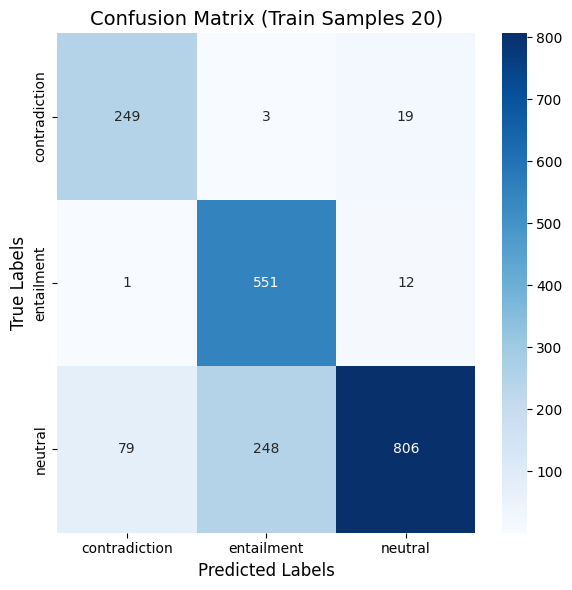


使用訓練資料數量: 50 筆
開始訓練...
Epoch 1: Train Loss=0.9608, Train Acc=0.5400 | Test Loss=0.4911, Test Acc=0.8989
Epoch 2: Train Loss=0.4677, Train Acc=0.8800 | Test Loss=0.3519, Test Acc=0.8887
Epoch 3: Train Loss=0.3109, Train Acc=0.9200 | Test Loss=0.3019, Test Acc=0.8882


/tmp/ipykernel_44187/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 4: Train Loss=0.2619, Train Acc=0.9200 | Test Loss=0.2993, Test Acc=0.8852
Epoch 5: Train Loss=0.2463, Train Acc=0.8800 | Test Loss=0.3349, Test Acc=0.8755
Epoch 6: Train Loss=0.2268, Train Acc=0.9000 | Test Loss=0.3879, Test Acc=0.8582
Epoch 7: Train Loss=0.2190, Train Acc=0.9000 | Test Loss=0.4472, Test Acc=0.8506
Epoch 8: Train Loss=0.2214, Train Acc=0.8600 | Test Loss=0.4281, Test Acc=0.8552
Epoch 9: Train Loss=0.2180, Train Acc=0.8600 | Test Loss=0.3833, Test Acc=0.8709
Epoch 10: Train Loss=0.1385, Train Acc=0.9600 | Test Loss=0.3560, Test Acc=0.8811
Test Accuracy for sample size 50: 0.8811
分類報告:
               precision    recall  f1-score   support

contradiction       0.83      0.87      0.85       271
   entailment       0.82      0.94      0.87       564
      neutral       0.94      0.85      0.89      1133

     accuracy                           0.88      1968
    macro avg       0.86      0.89      0.87      1968
 weighted avg       0.89      0.88      0.88      196

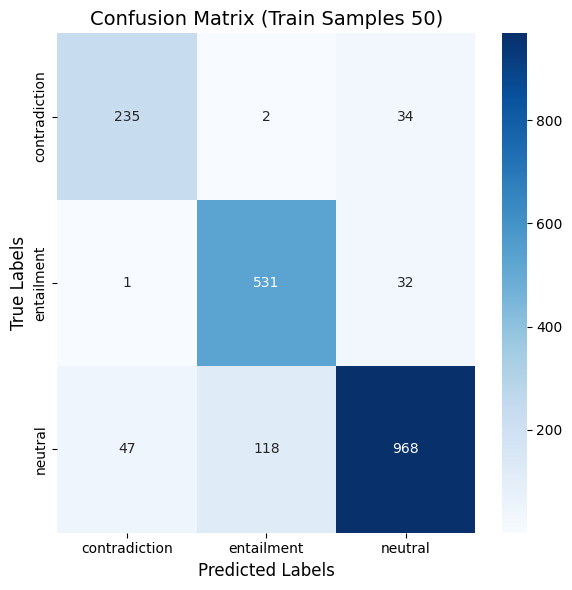


使用訓練資料數量: 70 筆
開始訓練...
Epoch 1: Train Loss=0.9710, Train Acc=0.4857 | Test Loss=0.3765, Test Acc=0.9101
Epoch 2: Train Loss=0.4020, Train Acc=0.8429 | Test Loss=0.2794, Test Acc=0.8923
Epoch 3: Train Loss=0.3545, Train Acc=0.8857 | Test Loss=0.2862, Test Acc=0.8862


/tmp/ipykernel_44187/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 4: Train Loss=0.2733, Train Acc=0.9286 | Test Loss=0.3508, Test Acc=0.8638
Epoch 5: Train Loss=0.2653, Train Acc=0.9000 | Test Loss=0.4104, Test Acc=0.8481
Epoch 6: Train Loss=0.3129, Train Acc=0.8571 | Test Loss=0.3696, Test Acc=0.8628
Epoch 7: Train Loss=0.2801, Train Acc=0.8714 | Test Loss=0.3044, Test Acc=0.8847
Epoch 8: Train Loss=0.2609, Train Acc=0.9286 | Test Loss=0.2845, Test Acc=0.8908
Epoch 9: Train Loss=0.2348, Train Acc=0.9143 | Test Loss=0.2897, Test Acc=0.8913
Epoch 10: Train Loss=0.2898, Train Acc=0.9286 | Test Loss=0.2935, Test Acc=0.8913
Test Accuracy for sample size 70: 0.8913
分類報告:
               precision    recall  f1-score   support

contradiction       0.79      0.90      0.84       271
   entailment       0.90      0.88      0.89       564
      neutral       0.92      0.89      0.90      1133

     accuracy                           0.89      1968
    macro avg       0.87      0.89      0.88      1968
 weighted avg       0.89      0.89      0.89      196

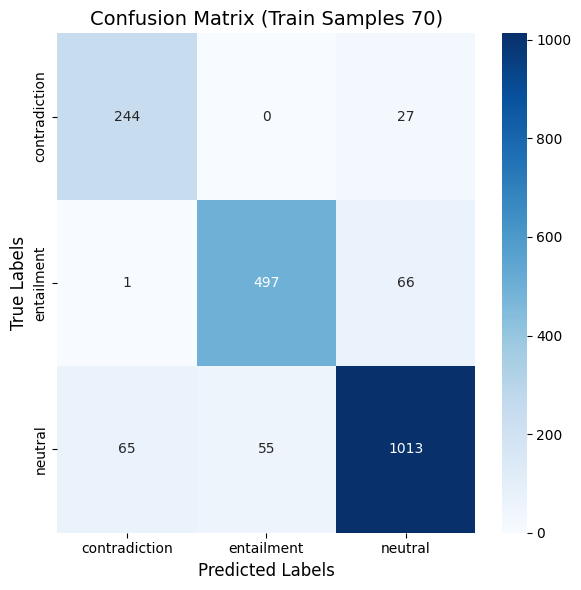


使用訓練資料數量: 100 筆
開始訓練...
Epoch 1: Train Loss=0.7705, Train Acc=0.6800 | Test Loss=0.3160, Test Acc=0.8938
Epoch 2: Train Loss=0.3211, Train Acc=0.9000 | Test Loss=0.2941, Test Acc=0.8847
Epoch 3: Train Loss=0.3417, Train Acc=0.8800 | Test Loss=0.2988, Test Acc=0.8862


/tmp/ipykernel_44187/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 4: Train Loss=0.2879, Train Acc=0.9200 | Test Loss=0.2712, Test Acc=0.8943
Epoch 5: Train Loss=0.3087, Train Acc=0.9100 | Test Loss=0.2743, Test Acc=0.8943
Epoch 6: Train Loss=0.2667, Train Acc=0.9100 | Test Loss=0.2944, Test Acc=0.8892
Epoch 7: Train Loss=0.2227, Train Acc=0.9100 | Test Loss=0.3227, Test Acc=0.8806
Epoch 8: Train Loss=0.2777, Train Acc=0.8800 | Test Loss=0.3118, Test Acc=0.8811
Epoch 9: Train Loss=0.2593, Train Acc=0.9400 | Test Loss=0.2969, Test Acc=0.8948
Epoch 10: Train Loss=0.1824, Train Acc=0.9100 | Test Loss=0.2893, Test Acc=0.8938
Test Accuracy for sample size 100: 0.8938
分類報告:
               precision    recall  f1-score   support

contradiction       0.87      0.84      0.85       271
   entailment       0.87      0.90      0.88       564
      neutral       0.91      0.90      0.91      1133

     accuracy                           0.89      1968
    macro avg       0.88      0.88      0.88      1968
 weighted avg       0.89      0.89      0.89      19

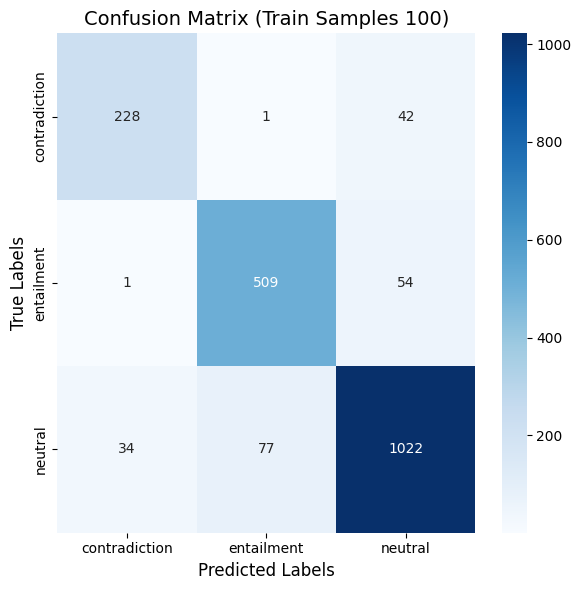


使用訓練資料數量: 300 筆
開始訓練...
Epoch 1: Train Loss=0.5354, Train Acc=0.8233 | Test Loss=0.2655, Test Acc=0.9014
Epoch 2: Train Loss=0.3363, Train Acc=0.9100 | Test Loss=0.2776, Test Acc=0.8958


/tmp/ipykernel_44187/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 3: Train Loss=0.3170, Train Acc=0.9033 | Test Loss=0.2574, Test Acc=0.9029
Epoch 4: Train Loss=0.2606, Train Acc=0.9167 | Test Loss=0.2536, Test Acc=0.9045
Epoch 5: Train Loss=0.2719, Train Acc=0.9100 | Test Loss=0.2526, Test Acc=0.9090
Epoch 6: Train Loss=0.2679, Train Acc=0.9133 | Test Loss=0.2526, Test Acc=0.9060
Epoch 7: Train Loss=0.2171, Train Acc=0.9167 | Test Loss=0.2587, Test Acc=0.9055
Epoch 8: Train Loss=0.2246, Train Acc=0.9267 | Test Loss=0.2622, Test Acc=0.8974
Epoch 9: Train Loss=0.2258, Train Acc=0.9367 | Test Loss=0.2532, Test Acc=0.9060
Epoch 10: Train Loss=0.2043, Train Acc=0.9267 | Test Loss=0.2607, Test Acc=0.8989
Test Accuracy for sample size 300: 0.8989
分類報告:
               precision    recall  f1-score   support

contradiction       0.86      0.87      0.86       271
   entailment       0.91      0.86      0.88       564
      neutral       0.90      0.93      0.91      1133

     accuracy                           0.90      1968
    macro avg       0.89  

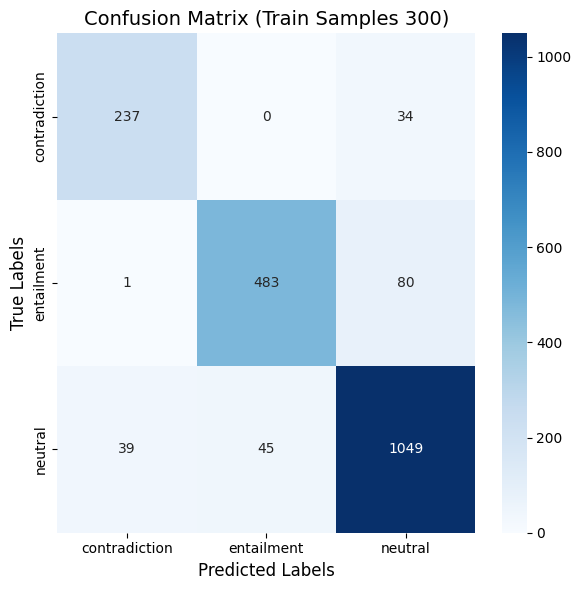


使用訓練資料數量: 1000 筆
開始訓練...
Epoch 1: Train Loss=0.3315, Train Acc=0.8850 | Test Loss=0.2555, Test Acc=0.9050


/tmp/ipykernel_44187/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 2: Train Loss=0.2675, Train Acc=0.9070 | Test Loss=0.2514, Test Acc=0.9085
Epoch 3: Train Loss=0.2556, Train Acc=0.9070 | Test Loss=0.2524, Test Acc=0.9045
Epoch 4: Train Loss=0.2516, Train Acc=0.9090 | Test Loss=0.2695, Test Acc=0.9136
Epoch 5: Train Loss=0.2334, Train Acc=0.9220 | Test Loss=0.2489, Test Acc=0.9111
Epoch 6: Train Loss=0.2353, Train Acc=0.9140 | Test Loss=0.2567, Test Acc=0.9075
Epoch 7: Train Loss=0.2292, Train Acc=0.9180 | Test Loss=0.2605, Test Acc=0.9045
Epoch 8: Train Loss=0.2440, Train Acc=0.9240 | Test Loss=0.2472, Test Acc=0.9090
Epoch 9: Train Loss=0.2171, Train Acc=0.9320 | Test Loss=0.2547, Test Acc=0.9111
Epoch 10: Train Loss=0.2327, Train Acc=0.9240 | Test Loss=0.2592, Test Acc=0.9090
Test Accuracy for sample size 1000: 0.9090
分類報告:
               precision    recall  f1-score   support

contradiction       0.95      0.84      0.89       271
   entailment       0.94      0.84      0.88       564
      neutral       0.89      0.96      0.92      1133


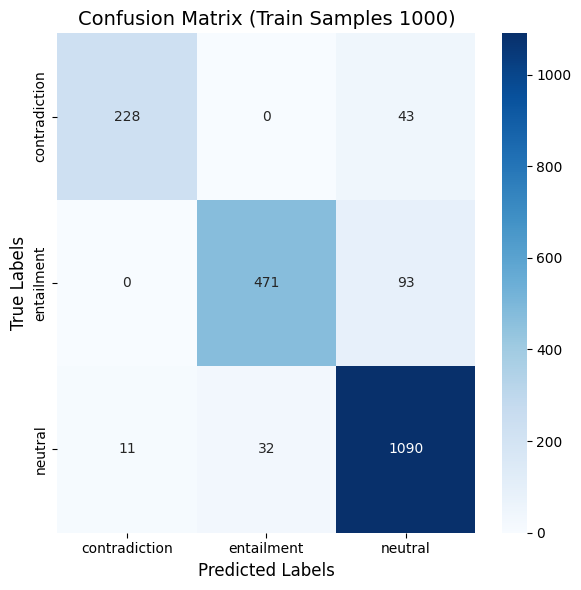


使用訓練資料數量: 7872 筆
開始訓練...


/tmp/ipykernel_44187/4184575118.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 1: Train Loss=0.2705, Train Acc=0.9040 | Test Loss=0.2402, Test Acc=0.9101
Epoch 2: Train Loss=0.2475, Train Acc=0.9127 | Test Loss=0.2368, Test Acc=0.9111
Epoch 3: Train Loss=0.2411, Train Acc=0.9103 | Test Loss=0.2375, Test Acc=0.9035
Epoch 4: Train Loss=0.2372, Train Acc=0.9104 | Test Loss=0.2424, Test Acc=0.9070
Epoch 5: Train Loss=0.2314, Train Acc=0.9136 | Test Loss=0.2391, Test Acc=0.9090
Epoch 6: Train Loss=0.2321, Train Acc=0.9162 | Test Loss=0.2384, Test Acc=0.9060
Epoch 7: Train Loss=0.2270, Train Acc=0.9164 | Test Loss=0.2416, Test Acc=0.9075
Epoch 8: Train Loss=0.2307, Train Acc=0.9139 | Test Loss=0.2655, Test Acc=0.8933
Epoch 9: Train Loss=0.2317, Train Acc=0.9129 | Test Loss=0.2353, Test Acc=0.9101
Epoch 10: Train Loss=0.2243, Train Acc=0.9188 | Test Loss=0.2460, Test Acc=0.9090
Test Accuracy for sample size 7872: 0.9090
分類報告:
               precision    recall  f1-score   support

contradiction       0.94      0.85      0.89       271
   entailment       0.88     

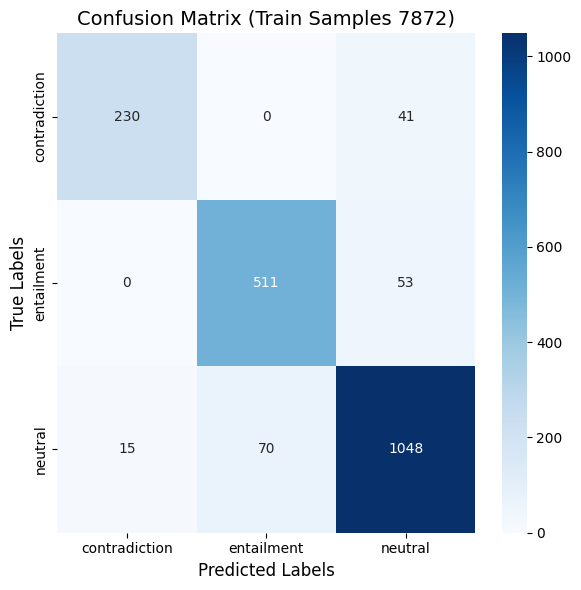

Accuracy Summary:
   train_samples  test_accuracy
0             20       0.816057
1             50       0.881098
2             70       0.891260
3            100       0.893801
4            300       0.898882
5           1000       0.909045
6           7872       0.909045
+----+-----------------+-----------------+
|    |   train_samples |   test_accuracy |
|----+-----------------+-----------------|
|  0 |              20 |        0.816057 |
|  1 |              50 |        0.881098 |
|  2 |              70 |        0.89126  |
|  3 |             100 |        0.893801 |
|  4 |             300 |        0.898882 |
|  5 |            1000 |        0.909045 |
|  6 |            7872 |        0.909045 |
+----+-----------------+-----------------+


In [5]:
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_ds)]
num_epochs = 10
learning_rate = 0.001
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_emb, _ = train_ds[0]
input_dim = sample_emb.shape[0]
hidden_dim = 128
num_classes = 3  

accuracy_summary = []

for size in sample_sizes:
    print(f"\n使用訓練資料數量: {size} 筆")
    # 從 train_ds 中取前 size 筆作為訓練子集
    train_subset = Subset(train_ds, range(size))
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    # 初始化 DNN 模型
    model = DNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    model.to(device)
    
    print("開始訓練...")
    test_acc, all_preds, all_labels = train_and_evaluate(model, train_loader, test_loader, num_epochs, learning_rate, device)
    print(f"Test Accuracy for sample size {size}: {test_acc:.4f}")
    
    print("分類報告:")
    print(classification_report(all_labels, all_preds, target_names=["contradiction", "entailment", "neutral"]))
    
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues,
                xticklabels=["contradiction", "entailment", "neutral"],
                yticklabels=["contradiction", "entailment", "neutral"])
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.title(f"Confusion Matrix (Train Samples {size})", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    accuracy_summary.append({"train_samples": size, "test_accuracy": test_acc})

summary_df = pd.DataFrame(accuracy_summary)
print("Accuracy Summary:")
print(summary_df)
print(tabulate(summary_df, headers='keys', tablefmt='psql'))
